In [30]:
from xarray import open_zarr
import eau_precpitable_CanESM5
import glob
import os
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Basic imports
try:
    from xhydro.extreme_value_analysis.parameterestimation import *
    from xhydro.extreme_value_analysis import Extremes, jl
    has_julia = True
except ImportError:
    print(
        "This notebook requires the `julia` programming language and the `juliacall` Python package to be installed."
    )
    has_julia = False

import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
# warnings.simplefilter("always", UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Données

<xarray.Dataset> Size: 27kB
Dimensions:             (time: 226, point: 28)
Coordinates:
    height              float64 8B 2.0
  * time                (time) int64 2kB 1925 1926 1927 1928 ... 2148 2149 2150
  * point               (point) int32 112B 1 2 3 4 5 6 7 ... 23 24 25 26 27 28
Data variables:
    precipitable_water  (point, time) float32 25kB 47.03 48.64 ... 96.48 122.3

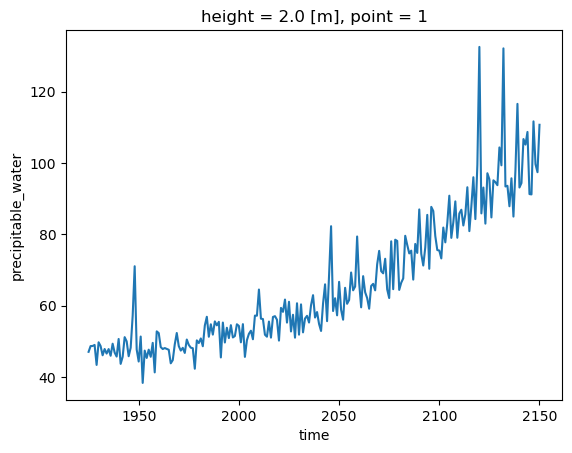

In [31]:
path_hist = glob.glob(os.path.join(eau_precpitable_CanESM5.__path__[0]))
da = open_zarr(path_hist[0], consolidated=True)

# Resample the data and update the time coordinate as before
da = da.resample(time='Y').max().compute()
da['time'] = da['time.year']

da = da.stack(point=("y", "x"))
da = da.assign_coords(point=np.arange(1, da.sizes["point"] + 1))
da = da.transpose('point', 'time')
da.precipitable_water[0,:].plot()
da



## Estimation de paramètres - Stationnaire

In [48]:
params = fit(da, dist="genextreme", method="ml", vars=["precipitable_water"], confidence_level=0.9)
params = params.transpose('point', 'dparams')
params

<xarray.Dataset> Size: 2kB
Dimensions:                   (point: 28, dparams: 3)
Coordinates:
    height                    float64 8B 2.0
  * point                     (point) int32 112B 1 2 3 4 5 6 ... 24 25 26 27 28
  * dparams                   (dparams) <U5 60B 'shape' 'loc' 'scale'
Data variables:
    precipitable_water        (point, dparams) float64 672B 0.2769 ... 12.29
    precipitable_water_lower  (point, dparams) float64 672B 0.1625 ... 10.92
    precipitable_water_upper  (point, dparams) float64 672B 0.3913 ... 13.83
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 15:20:39] fit: Estimate distribution parameters...

## Estimation de paramètres - Non-Stationnaire

In [33]:
params = fit(da, dist="genextreme", method="ml", vars=["precipitable_water"], locationcov=["time"])
params = params.transpose('point', 'dparams')
params


<xarray.Dataset> Size: 3kB
Dimensions:                   (point: 28, dparams: 4)
Coordinates:
    height                    float64 8B 2.0
  * point                     (point) int32 112B 1 2 3 4 5 6 ... 24 25 26 27 28
  * dparams                   (dparams) <U18 288B 'shape' 'loc' ... 'scale'
Data variables:
    precipitable_water        (point, dparams) float64 896B 0.0309 ... 7.034
    precipitable_water_lower  (point, dparams) float64 896B -0.05747 ... 6.322
    precipitable_water_upper  (point, dparams) float64 896B 0.1193 ... 7.828
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 14:08:49] fit: Estimate distribution parameters...

## Niveau de retour - Données

In [34]:
data = Extremes.dataset("fremantle")

# Creating the DataFrame
data = {
    'Year': [1897, 1898, 1899, 1900, 1901, 1903, 1904, 1905, 1906, 1908, 1909, 1912, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 
             1922, 1923, 1924, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1943, 
             1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 
             1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 
             1984, 1985, 1986, 1987, 1988, 1989],
    'SeaLevel': [1.58, 1.71, 1.4, 1.34, 1.43, 1.19, 1.55, 1.34, 1.37, 1.46, 1.92, 1.37, 1.19, 1.4, 1.28, 1.52, 1.52, 1.58, 1.49, 1.65,
                 1.37, 1.49, 1.46, 1.34, 1.74, 1.62, 1.46, 1.71, 1.74, 1.55, 1.43, 1.62, 1.49, 1.58, 1.34, 1.37, 1.62, 1.31, 1.43, 
                 1.49, 1.55, 1.71, 1.49, 1.46, 1.52, 1.58, 1.65, 1.49, 1.52, 1.52, 1.49, 1.62, 1.86, 1.58, 1.62, 1.46, 1.43, 1.46, 
                 1.62, 1.68, 1.83, 1.62, 1.46, 1.58, 1.77, 1.62, 1.71, 1.46, 1.6, 1.5, 1.6, 1.9, 1.7, 1.4, 1.8, 1.37, 1.46, 1.61, 
                 1.43, 1.67, 1.62, 1.57, 1.56, 1.46, 1.7, 1.51],
    'SOI': [-0.67, 0.57, 0.16, -0.65, 0.06, 0.47, 0.39, -1.78, 0.2, 0.28, 0.28, -0.97, -0.92, 0.16, 0.62, 2.12, 0.05, -1.09, 0.08, 
            0.66, 0.33, -0.36, 0.33, -0.24, 0.27, 0.43, 0.46, 0.03, 0.39, -0.68, 0.09, -0.01, 0.14, 0.03, 0.09, 0.86, 0.02, -1.52, 
            -1.44, 0.35, -0.27, 0.42, -0.79, 0.16, -0.24, -0.21, 1.49, -0.69, -0.23, -0.76, 0.23, 0.89, 1.0, -0.45, -0.5, -0.11, 
            0.28, -0.01, 0.38, -0.32, 0.53, -0.97, -0.53, 0.25, 0.19, -0.66, 0.28, 1.06, -0.88, 0.63, 0.97, 1.32, 0.06, -1.13, 
            -0.3, -0.08, -0.43, 0.06, -1.44, -0.94, -0.14, -0.07, -0.32, -1.47, 0.73, 0.61]
}

df = pd.DataFrame(data)

# Converting DataFrame to xarray.Dataset
ds = xr.Dataset(
    {
        'SeaLevel': ('time', df['SeaLevel']),
        'SOI': ('time', df['SOI'])
    },
    coords={
        'time': df['Year']
    }
)

ds


<xarray.Dataset> Size: 2kB
Dimensions:   (time: 86)
Coordinates:
  * time      (time) int64 688B 1897 1898 1899 1900 1901 ... 1986 1987 1988 1989
Data variables:
    SeaLevel  (time) float64 688B 1.58 1.71 1.4 1.34 1.43 ... 1.56 1.46 1.7 1.51
    SOI       (time) float64 688B -0.67 0.57 0.16 -0.65 ... -1.47 0.73 0.61

## Niveau de retour - Stationnaire

In [49]:
return_level_stat = return_level(ds, dist="genextreme", method="ml", return_period=1000, vars=["SeaLevel"])
return_level_stat

<xarray.Dataset> Size: 56B
Dimensions:       (return_level: 1)
Coordinates:
  * return_level  (return_level) <U12 48B 'return_level'
Data variables:
    SeaLevel      (return_level) float64 8B 1.987
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 15:24:25] fit: Estimate distribution parameters...

## Niveau de retour - Non-Stationnaire

In [60]:
return_level_nstat = return_level(ds, dist="genextreme", method="ml", return_period=1000, vars=["SeaLevel"], locationcov=["time", "SOI"])
return_level_nstat

<xarray.Dataset> Size: 1kB
Dimensions:       (return_level: 86)
Coordinates:
  * return_level  (return_level) int64 688B 1897 1898 1899 ... 1987 1988 1989
Data variables:
    SeaLevel      (return_level) float64 688B 1.867 1.937 1.917 ... 2.136 2.131
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-23 09:36:59] fit: Estimate distribution parameters...

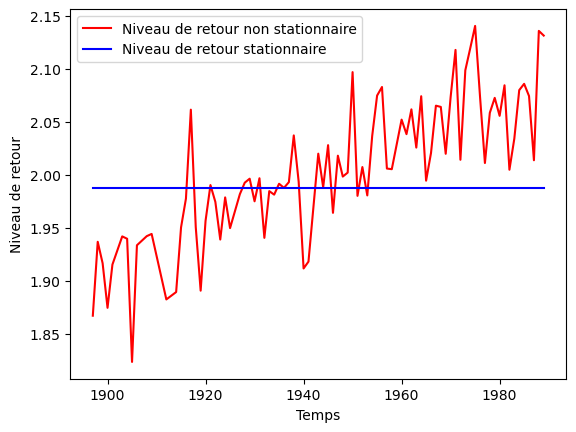

In [62]:
y_nstat = return_level_nstat.SeaLevel[:].values
y_stat = [return_level_stat.SeaLevel[:].values for i in range(len(y_nstat))]

x = ds.time
plt.plot(x, y_nstat, color="red", label="Niveau de retour non stationnaire")
plt.plot(x, y_stat, color="blue", label="Niveau de retour stationnaire")
plt.xlabel("Temps")
plt.ylabel("Niveau de retour")
plt.legend()
plt.show()
